# PVLIB Solar Modeling and Analysis

https://github.com/srlightfoote/PVLIB-Solar-Modeling/blob/master/PVLIB%2BTMY%2Bto%2BEnergy.ipynb

# import libraries

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pvlib as pvlib
import warnings
warnings.filterwarnings('ignore')

# define PV system

## Define Location

In [2]:
tz_local='US/Mountain'
location = pvlib.location.Location(latitude=32.2,longitude=-111,tz='UTC',altitude= 700,name='Tuscon')

In [3]:
# tz_local='US/Boston'  ###Boston
# location = pvlib.location.Location(latitude==42.3,longitude=-71.2,tz='UTC',altitude= 700,name='Boston')

In [4]:
# tz_local='US/Mountain'   ###Boulder
# location = pvlib.location.Location(latitude=40,longitude=-105.3,tz='UTC',altitude= 700,name='Boulder')

In [5]:
# tz_local='US/Charlotte'  ###Charlotte
# location = pvlib.location.Location(latitude=35.2,longitude=-80.8,tz='UTC',altitude= 700,name='Charlotte')

# download TMY

In [6]:
# api_key='zZN9lLYGEIuYd6ruQynCnwBYBAg0bwkkutTBLMfh'  # This was for wind toolkit data
api_key='FKLMGhrARB2HOafXdhTLSwtOD2G8Olh9t94KDxh6'   # This is for solar NSRDB data

api_key

'FKLMGhrARB2HOafXdhTLSwtOD2G8Olh9t94KDxh6'

In [7]:
# api_key='your+api_key'
interval='60'
utc='true'
# attributes = 'ghi,dhi,dni,wind_speed_10m_nwp,surface_air_temperature_nwp'
attributes = 'ghi,dhi,dni,wind_speed,air_temperature'

leap_year = 'false'
name  = 'Mohamed+Abuella'
reason_for_use = 'Research'
affiliation = 'UNCC'
email = 'mhdabuella@gmail.com'
mailing_list = 'false'

# get data
df = pd.read_csv('http://developer.nrel.gov/api'
                 '/solar/nsrdb_psm3_download.csv?wkt=POINT({lon}%20{lat})&'
                 'names={year}&leap_day={leap}&interval={interval}&utc={utc}&'
                 'full_name={name}&email={email}&affiliation={affiliation}&'
                 'mailing_list={mailing_list}&reason={reason}&api_key={api}&attributes={attr}'
                 .format(year='tmy', lat=location.latitude, lon=location.longitude, leap=leap_year, interval=interval, utc=utc, 
                         name=name, email=email, mailing_list=mailing_list, affiliation=affiliation, 
                         reason=reason_for_use, api=api_key, attr=attributes), skiprows=2)

df=df.set_index(pd.DatetimeIndex(pd.to_datetime(df[['Year','Month','Day','Hour','Minute']],utc=True)))
df=df.drop(['Year','Month','Day','Hour','Minute'],axis='columns')

# modify weather data column names to match pvlib conventions
df.columns=df.rename(str.lower,axis='columns').columns.str.replace(' ','_')
df.head()

,ghi,dhi,dni,wind_speed,temperature
2008-01-01 00:30:00,0,0,0,1.8,6
2008-01-01 01:30:00,0,0,0,1.9,4
2008-01-01 02:30:00,0,0,0,2.0,3
2008-01-01 03:30:00,0,0,0,2.2,2
2008-01-01 04:30:00,0,0,0,2.5,2


In [8]:
df.describe()

,ghi,dhi,dni,wind_speed,temperature
count,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000
mean,242.873630,54.075799,310.663699,2.421941,18.837215
std,328.443372,78.500048,388.532852,1.695037,9.662615
min,0.000000,0.000000,0.000000,0.100000,-3.000000
25%,0.000000,0.000000,0.000000,1.200000,11.000000
50%,0.000000,0.000000,0.000000,1.800000,19.000000
75%,494.000000,91.000000,755.250000,3.200000,26.000000
max,1088.000000,500.000000,1057.000000,10.300000,41.000000


In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 8760 entries, 2008-01-01 00:30:00 to 2012-12-31 23:30:00
Data columns (total 5 columns):
ghi            8760 non-null int64
dhi            8760 non-null int64
dni            8760 non-null int64
wind_speed     8760 non-null float64
temperature    8760 non-null int64
dtypes: float64(1), int64(4)
memory usage: 410.6 KB


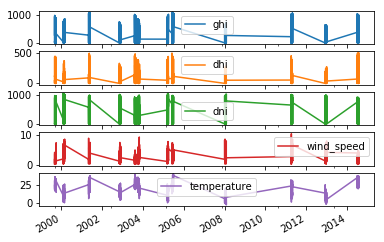

In [10]:
df.plot(subplots=True)
plt.show()

# Fixed Tilt Example

## Define system design

In [11]:
# define modules and inverters
cec_modules=pvlib.pvsystem.retrieve_sam('CECMod')
module=cec_modules['Yingli_Energy__China__YL300P_35b']
cec_inverters=pvlib.pvsystem.retrieve_sam('CECInverter')
inverter=cec_inverters['SMA_America__SC800CP_US_360V__CEC_2012_']

#missing module parameters for Desoto Model
module=module.append(pd.Series([1.121,-0.0002677],index=['EgRef','dEgdT']))

# define the pvsystem
system=pvlib.pvsystem.PVSystem(surface_tilt=22.5,
                        surface_azimuth=180,
                        albedo=.2,
                        modules_per_string=30,
                        strings_per_inverter=100,
                        module_parameters=module,
                        inverter_parameters=inverter,
                        name=location.name)
print(system)
print('module specs')
print(module)
print('inverter specs')
print(inverter)

PVSystem: 
  name: Tuscon
  surface_tilt: 22.5
  surface_azimuth: 180
  module: None
  inverter: None
  albedo: 0.2
  racking_model: open_rack_cell_glassback
module specs
BIPV                   N
Date            7/1/2013
T_NOCT              45.3
A_c                 1.95
N_s                   72
I_sc_ref            8.77
V_oc_ref            46.3
I_mp_ref            8.17
V_mp_ref            36.7
alpha_sc        0.004122
beta_oc         -0.17038
a_ref             1.9359
I_L_ref            8.784
I_o_ref         3.54e-10
R_s                0.489
R_sh_ref          296.18
Adjust           -0.6356
gamma_r            -0.46
Version           NRELv1
PTC                270.7
Technology    Multi-c-Si
EgRef              1.121
dEgdT         -0.0002677
dtype: object
inverter specs
Vac          3.600000e+02
Paco         8.230000e+05
Pdco         8.385667e+05
Vdco         6.357582e+02
Pso          2.247796e+03
C0          -1.640000e-08
C1           1.640000e-05
C2           2.860000e-03
C3           6.35

## Define the Irradiance and PV Modeling Methods

In [12]:
mc=pvlib.modelchain.ModelChain(system,location,
                               aoi_model='physical',
                               transposition_model='perez',
                               dc_model='singlediode',
                               ac_model='snlinverter',
                               spectral_model='no_loss',
                               losses_model='pvwatts',
                               name=location.name)
print(mc)

ModelChain: 
  name: Tuscon
  orientation_strategy: None
  clearsky_model: ineichen
  transposition_model: perez
  solar_position_method: nrel_numpy
  airmass_model: kastenyoung1989
  dc_model: desoto
  ac_model: snlinverter
  aoi_model: physical_aoi_loss
  spectral_model: no_spectral_loss
  temp_model: sapm_temp
  losses_model: pvwatts_losses


## Run the Model
The model runs with some warnings

In [13]:
#run model
mc.run_model(times=df.index,weather=df)

# combine results into existing
df_fixed=pd.concat([df,mc.total_irrad],axis=1)
df_fixed=pd.concat([df_fixed,mc.temps],axis=1)
df_fixed=pd.concat([df_fixed,mc.dc],axis=1)
df_fixed['p_ac']=mc.ac

# convert to local timezone
df_fixed.index=df_fixed.index.tz_localize('UTC').tz_convert(tz_local)
df_fixed.head()

,ghi,dhi,dni,wind_speed,temperature,temp_air,poa_global,poa_direct,poa_diffuse,poa_sky_diffuse,...,temp_cell,temp_module,i_sc,v_oc,i_mp,v_mp,p_mp,i_x,i_xx,p_ac
2007-12-31 17:30:00-07:00,0,0,0,1.8,6,20,0.0,0.0,0.0,0.0,...,20.0,20.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-311.819427
2007-12-31 18:30:00-07:00,0,0,0,1.9,4,20,0.0,-0.0,0.0,0.0,...,20.0,20.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-311.819427
2007-12-31 19:30:00-07:00,0,0,0,2.0,3,20,0.0,-0.0,0.0,0.0,...,20.0,20.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-311.819427
2007-12-31 20:30:00-07:00,0,0,0,2.2,2,20,0.0,-0.0,0.0,0.0,...,20.0,20.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-311.819427
2007-12-31 21:30:00-07:00,0,0,0,2.5,2,20,0.0,-0.0,0.0,0.0,...,20.0,20.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-311.819427


In [14]:
df_fixed.describe()
df_fixed.index
df.loc[df['ghi'].idxmax()]

ghi            1088.0
dhi             123.0
dni             976.0
wind_speed        4.9
temperature      36.0
temp_air         20.0
Name: 2005-06-17 19:30:00, dtype: float64

## Supporting Plots

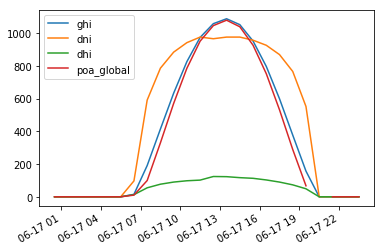

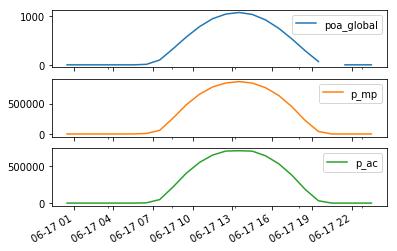

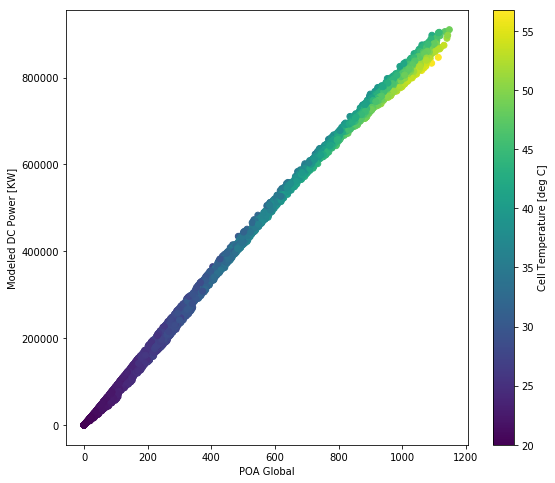

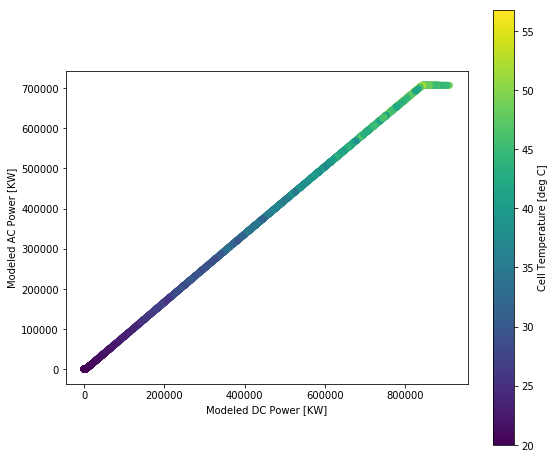

In [15]:
df_fixed.loc['2005-06-17',['ghi','dni','dhi','poa_global']].plot()
plt.show()

df_fixed.loc['2005-06-17',['poa_global','p_mp','p_ac']].plot(subplots=True)
plt.show()

fig = plt.figure(figsize=(9,8))
ax = fig.add_subplot(111)
sc = ax.scatter(x=df_fixed['poa_global'],y=df_fixed['p_mp'],c=df_fixed['temp_cell'])
ax.set_xlabel('POA Global')
ax.set_ylabel('Modeled DC Power [KW]')
fig.colorbar(sc, label='Cell Temperature [deg C]')
plt.show()

fig = plt.figure(figsize=(9,8))
ax = fig.add_subplot(111, aspect='equal')
sc = ax.scatter(x=df_fixed['p_mp'],y=df_fixed['p_ac'],c=df_fixed['temp_cell'])
ax.set_xlabel('Modeled DC Power [KW]')
ax.set_ylabel('Modeled AC Power [KW]')
fig.colorbar(sc, label='Cell Temperature [deg C]')
plt.show()

## Totals

In [16]:
df_fixed['month']=df_fixed.index.month
monthly_fixed=df_fixed[['month','ghi','poa_global','p_mp','p_ac']].groupby('month').sum()*.001
monthly_fixed['total_losses']=1-monthly_fixed.p_ac/monthly_fixed.p_mp
round(monthly_fixed,3)

,ghi,poa_global,p_mp,p_ac,total_losses
month,,,,,
1,111.266,162.164,135081.306,113065.677,0.163
2,127.406,168.891,139765.113,116924.370,0.163
3,186.405,218.765,179197.914,149471.017,0.166
4,220.041,232.110,189999.219,157747.824,0.170
5,254.259,247.462,200811.504,167781.314,0.164
6,251.354,236.102,192721.074,161212.484,0.163
7,211.463,203.682,167098.867,139805.713,0.163
8,205.204,210.171,171791.921,143738.573,0.163
9,180.734,203.738,165339.584,138369.835,0.163


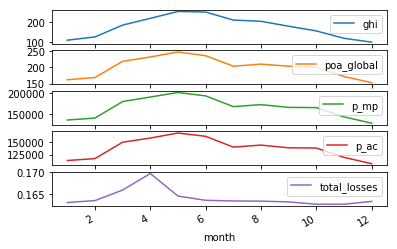

In [17]:
monthly_fixed.plot(subplots=True)
plt.show()

In [18]:
round(monthly_fixed.agg(['sum','mean']),3)

,ghi,poa_global,p_mp,p_ac,total_losses
sum,2127.573,2408.729,1976607.284,1652144.168,1.968
mean,177.298,200.727,164717.274,137678.681,0.164


# Single Axis Tracking Example

## Define system design

In [19]:
tracking_system= pvlib.tracking.SingleAxisTracker(albedo=.2,
                        modules_per_string=30,
                        strings_per_inverter=100,
                        module_parameters=module,
                        inverter_parameters=inverter,
                        name=location.name+' Tracking',
                        axis_tilt=0,
                        axis_azimuth=180,
                        max_angle=52,
                        backtrack=True,
                        gcr=.5)
print(tracking_system)

SingleAxisTracker: 
  axis_tilt: 0
  axis_azimuth: 180
  max_angle: 52
  backtrack: True
  gcr: 0.5
  name: Tuscon Tracking
  surface_tilt: None
  surface_azimuth: None
  module: None
  inverter: None
  albedo: 0.2
  racking_model: open_rack_cell_glassback


## Define the Irradiance and PV Modeling Methods

In [20]:
mc=pvlib.modelchain.ModelChain(tracking_system,
                               location,
                               aoi_model='physical',
                               transposition_model='perez',
                               dc_model='singlediode',
                               ac_model='snlinverter',
                               spectral_model='no_loss',
                               losses_model='pvwatts',
                               name=tracking_system.name)
print(mc)

ModelChain: 
  name: Tuscon Tracking
  orientation_strategy: None
  clearsky_model: ineichen
  transposition_model: perez
  solar_position_method: nrel_numpy
  airmass_model: kastenyoung1989
  dc_model: desoto
  ac_model: snlinverter
  aoi_model: physical_aoi_loss
  spectral_model: no_spectral_loss
  temp_model: sapm_temp
  losses_model: pvwatts_losses


## Run the Model
The model runs with some warnings

In [21]:
#run model
mc.run_model(times=df.index,weather=df)

# combine results into existing
df_tracking=pd.concat([df,mc.total_irrad],axis=1)
df_tracking=pd.concat([df_tracking,mc.temps],axis=1)
df_tracking=pd.concat([df_tracking,mc.dc],axis=1)
df_tracking['p_ac']=mc.ac

# convert to local timezone
df_tracking.index=df_tracking.index.tz_localize('UTC').tz_convert(tz_local)
df_tracking.head()

,ghi,dhi,dni,wind_speed,temperature,temp_air,poa_global,poa_direct,poa_diffuse,poa_sky_diffuse,...,temp_cell,temp_module,i_sc,v_oc,i_mp,v_mp,p_mp,i_x,i_xx,p_ac
2007-12-31 17:30:00-07:00,0,0,0,1.8,6,20,0.0,-0.0,0.0,0.0,...,20.0,20.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-311.819427
2007-12-31 18:30:00-07:00,0,0,0,1.9,4,20,0.0,-0.0,0.0,0.0,...,20.0,20.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-311.819427
2007-12-31 19:30:00-07:00,0,0,0,2.0,3,20,0.0,-0.0,0.0,0.0,...,20.0,20.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-311.819427
2007-12-31 20:30:00-07:00,0,0,0,2.2,2,20,0.0,-0.0,0.0,0.0,...,20.0,20.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-311.819427
2007-12-31 21:30:00-07:00,0,0,0,2.5,2,20,0.0,-0.0,0.0,0.0,...,20.0,20.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-311.819427


## Supporting Plots

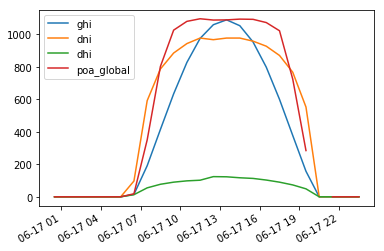

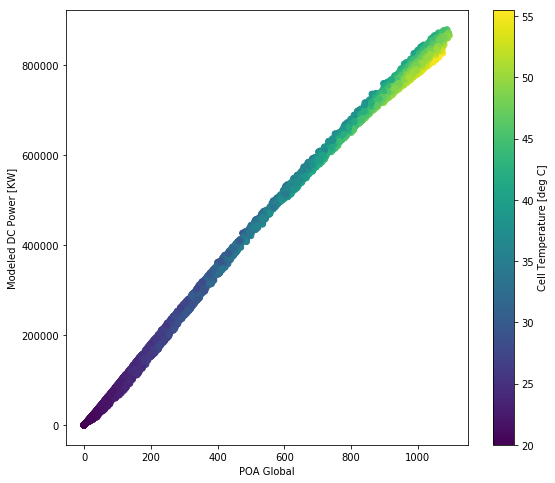

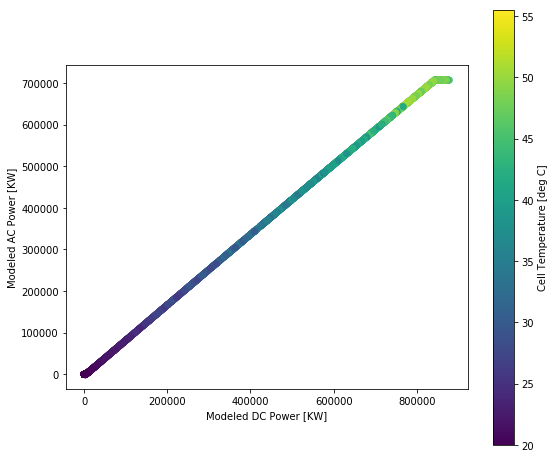

In [22]:
df_tracking.loc['2005-06-17',['ghi','dni','dhi','poa_global']].plot()
plt.show()

fig = plt.figure(figsize=(9,8))
ax = fig.add_subplot(111)
sc = ax.scatter(x=df_tracking['poa_global'],y=df_tracking['p_mp'],c=df_tracking['temp_cell'])
ax.set_xlabel('POA Global')
ax.set_ylabel('Modeled DC Power [KW]')
fig.colorbar(sc, label='Cell Temperature [deg C]')
plt.show()

fig = plt.figure(figsize=(9,8))
ax = fig.add_subplot(111, aspect='equal')
sc = ax.scatter(x=df_tracking['p_mp'],y=df_tracking['p_ac'],c=df_tracking['temp_cell'])
ax.set_xlabel('Modeled DC Power [KW]')
ax.set_ylabel('Modeled AC Power [KW]')
fig.colorbar(sc, label='Cell Temperature [deg C]')
plt.show()

## Totals

In [23]:
df_tracking['month']=df_tracking.index.month
monthly_tracking=df_tracking[['month','ghi','poa_global','p_mp','p_ac']].groupby('month').sum()*.001
monthly_tracking['total_losses']=1-monthly_tracking.p_ac/monthly_tracking.p_mp
round(monthly_tracking,3)

,ghi,poa_global,p_mp,p_ac,total_losses
month,,,,,
1,111.266,149.515,125722.643,105242.017,0.163
2,127.406,168.888,141174.588,118202.278,0.163
3,186.405,244.618,201605.223,168931.625,0.162
4,220.041,285.018,232918.412,194764.674,0.164
5,254.259,326.068,262876.083,219748.065,0.164
6,251.354,320.452,259814.384,217125.255,0.164
7,211.463,260.843,212559.807,178079.769,0.162
8,205.204,257.390,209563.084,175545.214,0.162
9,180.734,236.226,192359.230,161133.205,0.162


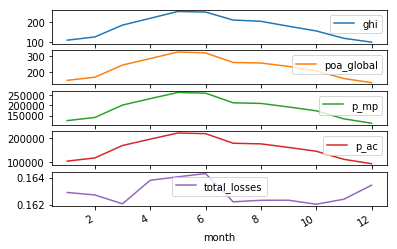

In [24]:
monthly_tracking.plot(subplots=True)
plt.show()

In [25]:
round(monthly_tracking.agg(['sum','mean']),3)

,ghi,poa_global,p_mp,p_ac,total_losses
sum,2127.573,2753.605,2259818.64,1891534.781,1.955
mean,177.298,229.467,188318.22,157627.898,0.163
